# Tabular Playground Series - Nov 21

For the Playground Series of November '21, we aim to build a model to identify spam emails via various extracted features from the email. Our data consists of 100 feature variables and our target variable is binary classification. We will first perform some basic EDA to take a better look at this data following which we will start working on our models. 

## Plan

Moving forward this is the plan we are going to be following. Keep in mind, this is not a concrete plan and I might change it as we move through the notebook. This will show you my process on how I approach these datasets.

- *Memory Reduction*
- *Sampling to Reduce Training Time*
- *Basic EDA*
- *Model Development*
- *Hyperparameter Tuning*
- *Feature Importance from top models*
- *Selecting the best Model*

## Imports 

Let's import some of the libraries we will be using throughout the notebook

In [1]:
# Data Import on Kaggle
import os
import time
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Importing processing libraries
import numpy as np
import pandas as pd

# Importing Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for the metrics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Importing libraries for the model
import xgboost as xgb 
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

# sklearn imports for analysis
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import randint

/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


In [2]:
data = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv')
test_data = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')

In [3]:
data = data.drop('id', axis=1)

## Memory Reduction

If you don't have any issues with memory, you can go ahead and skip this step. 
Here, we will take a look at the memory consumption by the current data and each feature following which we will try to reduce it to some extent. 

There are several other methods to save RAM - you can refer to this article on [14 tips to save RAM memory](https://www.kaggle.com/pavansanagapati/14-simple-tips-to-save-ram-memory-for-1-gb-dataset). 

In [4]:
memory_usage = data.memory_usage(deep=True) / 1024 ** 2
print('memory usage of features: \n', memory_usage.head(7))
print('memory usage sum: ',memory_usage.sum())

memory usage of features: 
 Index    0.000122
f0       4.577637
f1       4.577637
f2       4.577637
f3       4.577637
f4       4.577637
f5       4.577637
dtype: float64
memory usage sum:  462.3414306640625


In [5]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

data = reduce_memory_usage(data, verbose=True)
test_data = reduce_memory_usage(test_data, verbose=True)

Mem. usage decreased to 115.01 Mb (75.1% reduction)
Mem. usage decreased to 105.06 Mb (74.8% reduction)


In [6]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
count,600000.000000,600000.000000,600000.0000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.059357,NaN,0.106689,NaN,NaN,NaN,NaN,0.506010
std,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.119446,0.000000,0.209106,0.000000,0.000000,0.000000,0.000000,0.499964
min,-3.796875,-1.223633,-1843.0000,-1.368164,-3.207031,-1.169922,-1.059570,-1.282227,-1.242188,-2.578125,...,-1.217773,-9.765625,-4.667969,-3.101562,-1.276367,-1.584961,-1.254883,-3.994141,-2.783203,0.000000
25%,0.026215,1.186523,43.5625,1.442383,0.019714,1.260742,1.385742,1.333984,1.291992,0.019562,...,1.213867,0.018906,0.024490,0.017059,0.025467,1.248047,1.347656,0.013535,0.018112,0.000000
50%,0.097778,2.515625,133.6250,2.634766,0.061584,2.589844,2.800781,2.558594,2.476562,0.058746,...,2.386719,0.068909,0.056641,0.063416,0.062164,2.601562,2.681641,0.058044,0.058472,1.000000
75%,0.397217,3.787109,302.2500,3.908203,0.112732,3.814453,3.996094,3.824219,3.804688,0.101074,...,3.693359,0.125122,0.088135,0.113098,0.101990,3.820312,3.839844,0.110718,0.104858,1.000000
max,8.781250,6.226562,6120.0000,6.519531,8.265625,6.515625,6.585938,6.257812,6.390625,7.078125,...,6.574219,18.406250,10.210938,8.625000,3.656250,6.253906,6.144531,10.765625,5.988281,1.000000


## Sampling Data

Now that we have reduced the memory usage by over 70%, let's sample the data. 

Why are we doing this? Well, you don't have to. But if you're like me and own a Macbook Air that can't handle a dataset bigger than 100mb, this might be a good idea.

When we are performing model selection and hyperparameter tuning later, we can't afford to let the notebook run for hours on end testing every model. Doing this, preserves the distributions of each feature while taking only 20% of the entire dataset and we can reduce the training time by using this sampled data.

We can then perform EDA, modelling, hyperparameter tuning and other steps on this sampled data. Once we decide on the model we want to use and improve its performance, we can train the final model on the entire dataset again.

In [7]:
sample_df = data.sample(int(len(data) * 0.2))
sample_df.shape

(120000, 101)

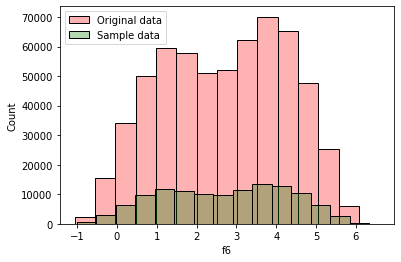

In [8]:
# Let's confirm if the sampling is retaining the feature distributions

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=data, x="f6", label="Original data", color="red", alpha=0.3, bins=15
)
sns.histplot(
    data=sample_df, x="f6", label="Sample data", color="green", alpha=0.3, bins=15
)

plt.legend()
plt.show();

## EDA

Let's start looking at any correlations that might exist among the features.
We will also be looking at the densities of every feature.

In [9]:
sample_df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
112633,0.497070,3.828125,7.617188,0.224976,0.051239,1.332031,5.125000,1.350586,1.248047,0.008644,...,0.896484,0.103516,0.093872,0.022690,0.051941,2.185547,1.306641,-0.031647,-0.006981,0
239524,-0.002687,0.327637,219.000000,3.853516,0.384033,2.185547,5.242188,1.916016,0.453369,0.033478,...,-0.023056,-0.003380,0.072266,0.088379,0.021378,4.464844,0.430420,1.143555,0.125488,0
302100,0.759766,4.894531,123.437500,0.932617,-0.048462,2.878906,4.289062,3.851562,0.132812,0.016327,...,0.615234,-0.002863,0.033478,0.012695,0.081421,4.917969,1.684570,0.539062,0.059326,0
481759,0.119385,4.937500,224.125000,3.964844,0.136719,0.733398,1.766602,1.166992,2.707031,0.062927,...,-0.265137,-0.004669,0.072754,-0.035645,0.102051,3.667969,2.498047,0.065613,0.003397,1
593056,0.023193,0.274902,2550.000000,5.828125,0.026352,0.817871,2.906250,0.565918,4.296875,0.055023,...,2.132812,0.148926,0.011230,0.166382,0.051117,3.093750,4.222656,0.045441,0.743652,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447154,0.044983,5.328125,885.000000,1.521484,0.005226,0.854004,2.662109,0.376953,1.820312,0.074890,...,3.398438,0.377930,0.013077,0.131470,-0.048279,4.945312,2.867188,1.695312,0.006927,1
94997,0.249268,2.519531,72.812500,0.538086,0.019714,0.035980,3.343750,2.042969,1.021484,0.052917,...,1.763672,0.012672,0.066528,0.100342,0.087402,5.429688,0.278564,0.000953,0.063538,0
437043,-0.023102,4.214844,1276.000000,3.832031,0.104675,2.437500,5.382812,0.898438,0.096863,0.042206,...,3.558594,0.153931,0.001089,0.105591,0.048462,4.925781,2.830078,-0.058960,0.041565,1
496636,0.038300,2.648438,218.875000,-0.277100,0.072876,0.669434,2.546875,3.888672,0.397461,0.008972,...,1.025391,0.987793,0.082642,0.514648,0.079956,0.964844,4.582031,0.496582,0.063110,1


In [10]:
# Check na values
print('Amount of existing NaN values', sample_df.isna().sum())

print('---------')
# Target Class Distribution
target_dist = sample_df.target.value_counts()
print('Distribution of Target Class \n',target_dist)
print(target_dist[0]/(target_dist[0] + target_dist[1]))

Amount of existing NaN values f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 101, dtype: int64
---------
Distribution of Target Class 
 1    60748
0    59252
Name: target, dtype: int64
0.4937666666666667


There doesn't seem to be any nan values in the data. Also, the target class is split evenly between the two groups

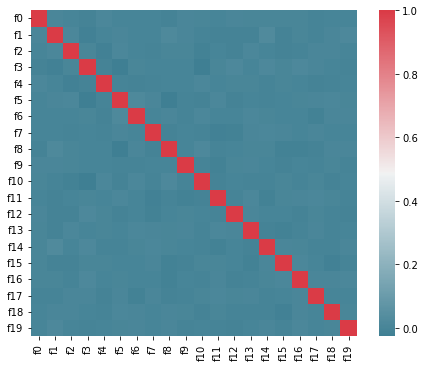

In [11]:
f, ax = plt.subplots(figsize=(8, 6))
corr = sample_df.iloc[:,:20].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Before we look at distributions, we need to split the data into continuous and categorical variables.

In [12]:
cat_variables = []

for column in sample_df.columns:
    if len(sample_df[column].unique()) < 10:
        cat_variables.append(column)
print(cat_variables)

['target']


So, we have no  categorical features in this dataset. Let's find the  distributions of all the features using kdeplot.

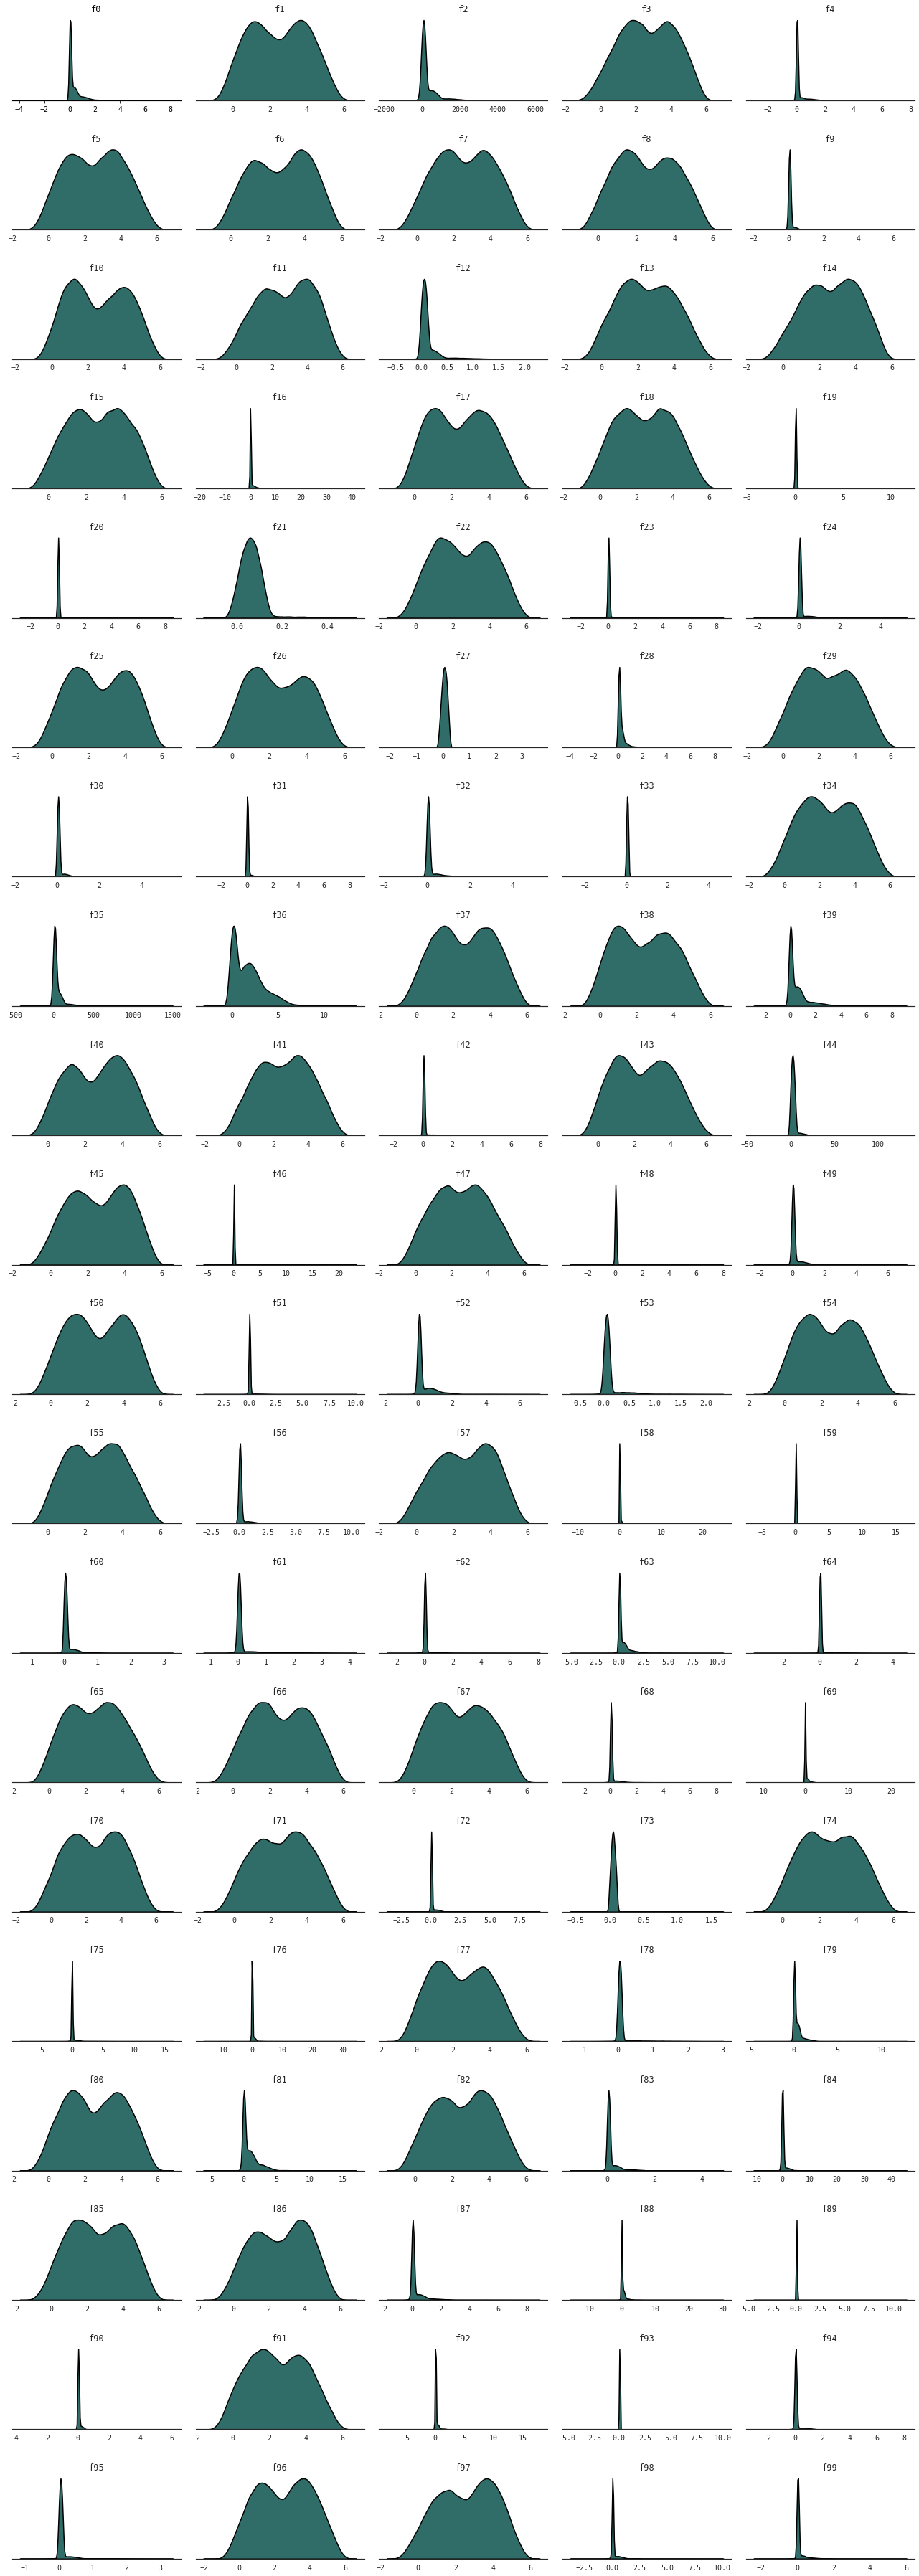

In [13]:
fig = plt.figure(figsize = (18, 50))

for i in range(len(sample_df.columns.tolist()[:100])):
    plt.subplot(20,5,i+1)
    sns.set_style("white")
    plt.title(sample_df.columns.tolist()[:100][i], size = 12, fontname = 'monospace')
    a = sns.kdeplot(sample_df[sample_df.columns.tolist()[:100][i]], color = '#1a5d57', shade = True, alpha = 0.9, linewidth = 1.5, edgecolor = 'black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)

plt.show()

## Data Preparation

In this section, we will do some preprocessing. This part involves Feature Scaling and Splitting the data into Train and Test sets.

### Scaling 

While most of the models I plan to use in the 'model selection' section will not require any form of feature scaling (like, XGBoost, Random Forest, etc.), some of them (like, KNN and SVM) need it to work. 

##### Why

In general, algorithms that exploit distances or similarities (e.g. in the form of scalar product) between data samples, such as K-NN and Support Vector Machines, are sensitive to feature transformations.

Graphical-model based classifiers, such as Fisher LDA or Naive Bayes, as well as Decision trees and Tree-based ensemble methods (Random Forests, XGBoost) are invariant to feature scaling, but still, it might be a good idea to rescale/standardize your data.

In [14]:
features = data.columns
scale = MinMaxScaler()
sample_df[features]=scale.fit_transform(sample_df[features])
sample_df[features]= scale.transform(sample_df[features])  

print('Data scaled using : ', scale)

Data scaled using :  MinMaxScaler()


### Train-Test Split

Let's split our sampled data into train and test sets

In [15]:
X = sample_df.drop('target', axis=1)
y = sample_df.target

X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.7, random_state=42)

del sample_df # we do this to remove sample_df from memory

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(84000, 100)
(84000,)
(36000, 100)
(36000,)


In [17]:
id_test_submission = test_data.id
X_test_submission = test_data.drop('id', axis=1)

del test_data

## Model Selection

Finally, now that we're done with the preprocessing and EDA, we are going to take a look at how some basic models perform on a subset of the data (20%) without any parameter tuning. We can then retrain and evaluate the top performing models with a bigger dataset and tuned parameters.

You can take a look at the model_dict and add any models that you think might perform well. Or leave a comment and I'll add them asap!


*P.S: Kaggle has a time-out error if the run time of a notebook exceeds a certain time limit. So, I'll comment some of these models out. However, I'll keep the top performing models uncommented.*

In [18]:
model_dict = {
    'ADABoost': AdaBoostClassifier(),
    'Light GBM': lgb.LGBMClassifier(random_state=0, verbose=-1),
    'Logistic Reg': LogisticRegression(random_state=0, max_iter=350, solver='lbfgs'),
    'Naive Bayes': GaussianNB(), 
#     'K Nearest Classifier': KNeighborsClassifier(),
            }
model_list = []
train_acc_list = []
test_acc_list = []
counter_list = []

for model, clf in model_dict.items():
    start_time = time.time()

    clf.fit(X_train, y_train)
    
    # test results
    test_pred = clf.predict(X_test)
    test_acc = roc_auc_score(y_test, test_pred)
    
    # train results
    train_pred =  clf.predict(np.float32(X_train))
    train_acc = roc_auc_score(y_train, train_pred)

    print(model, 'Model')
    print('Classification Report \n',classification_report(y_test, test_pred))
    print('Confusion Matrix \n',confusion_matrix(y_test,test_pred))
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print("\n Ran in %s seconds" % (time.time() - start_time))
    print('--------------------------------')
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)   
    

results = pd.DataFrame({"model": model_list, "train_accuracy": train_acc_list, "test_acc": test_acc_list})

ADABoost Model
Classification Report 
               precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     17862
         1.0       0.66      0.68      0.67     18138

    accuracy                           0.66     36000
   macro avg       0.66      0.66      0.66     36000
weighted avg       0.66      0.66      0.66     36000

Confusion Matrix 
 [[11576  6286]
 [ 5794 12344]]
Train Accuracy:  0.6726815645182297
Test Accuracy:  0.6643199361384686

 Ran in 29.014694690704346 seconds
--------------------------------
Light GBM Model
Classification Report 
               precision    recall  f1-score   support

         0.0       0.70      0.67      0.68     17862
         1.0       0.69      0.71      0.70     18138

    accuracy                           0.69     36000
   macro avg       0.69      0.69      0.69     36000
weighted avg       0.69      0.69      0.69     36000

Confusion Matrix 
 [[11964  5898]
 [ 5241 12897]]
Train Accuracy:  0.74624912

In [19]:
results

,model,train_accuracy,test_acc
0,ADABoost,0.672682,0.664320
1,Light GBM,0.746249,0.690425
2,Logistic Reg,0.702302,0.703584
3,Naive Bayes,0.501057,0.501297


# Conclusion

This notebook was an introduction on how to perform EDA, Feature Scaling and build some models on the default parameters. We also went over how to deal with large datasets and limit the use of RAM using memroy reduction techniques and sampling to reduce the training time. With these skills, you can add to the EDA and integrate unique visualiations that you find might be useful. 

### Next Steps

In the future, I will be adding more models to this notebook, but more importantly, I will be working on Feature Engineering and Hyperparameter Tuning in order to improve the predicitive performance of these models.

P.S: Feature Engineering is the process of extracting useful features and attributes from the data to imrpove our model while Hyperparameter Tuning is the process of picking a model and changing each parameter to see which ones perform the best (either manually or using GridSearchCV).

## Submission

Keep in mind this submission will not yield great results since its trained on the basic model with default parameters. We will need to work on the models further and try to improve the submission results.

In [20]:
X_final = data.drop('target', axis=1)
y_final = data.target

model = lgb.LGBMClassifier(random_state=0, verbose=-1)
model.fit(X_final, y_final)
test_pred = model.predict(X_test_submission)

In [21]:
new_df = pd.DataFrame({'id': id_test_submission, 'target': test_pred})
new_df.to_csv('./lgbm_submission.csv', index=False)